In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from time import time
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4)

In [4]:
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("Image shape: (%d, %d)" % (h, w))

Total dataset size:
n_samples: 3023
n_features: 1850
n_classes: 62
Image shape: (50, 37)


In [5]:
# class_counts = np.bincount(y_1)

# for i, count in enumerate(class_counts):
#     print(f"{target_names[i]}: {count} ảnh")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [22]:

def show_misclassified_images(X_test, y_test, y_pred, target_names, image_shape= (50, 37), num_images_to_show=10):
    misclassified_indices = np.where(y_test != y_pred)[0]

    misclassified_images = X_test[misclassified_indices]
    misclassified_true_labels = y_test[misclassified_indices]
    misclassified_pred_labels = y_pred[misclassified_indices]

    num_misclassified = len(misclassified_indices)
    print(f'Total misclassified images: {num_misclassified}')

    num_images_to_display = min(num_misclassified, num_images_to_show)

    fig, axes = plt.subplots(2, num_images_to_display // 2, figsize=(12, 6))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    for i, ax in enumerate(axes.flat):
        ax.imshow(misclassified_images[i].reshape(image_shape), cmap='gray')
        true_label_name = target_names[misclassified_true_labels[i]]
        pred_label_name = target_names[misclassified_pred_labels[i]]
        ax.set_title(f'True: {true_label_name}\nPredicted: {pred_label_name}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

  # SVM

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
clf = SVC(class_weight="balanced",random_state=42)

In [9]:
parameters = {"C":[1, 0.001, 100],
             "gamma":[1e-07,1e-03,1e-04],
              "kernel":["rbf","linear","poly"]
             }
grid_search = GridSearchCV(clf,parameters,n_jobs=2,cv=5)

In [10]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             n_jobs=2,
             param_grid={'C': [1, 0.001, 100], 'gamma': [1e-07, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']})

In [11]:
print('The best model:\n', grid_search.best_params_)

The best model:
 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [12]:
clf_best = grid_search.best_estimator_
y_pred = clf_best.predict(X_test)

In [13]:
print(f"THe accuracy is :{clf_best.score(X_test,y_test)*100:.1f}%")
# print(classification_report(y_test,y_pred,target_names=target_names))

THe accuracy is :63.0%


In [ ]:
show_misclassified_images(X_test, y_test, y_pred, target_names)

# SVM + PCA

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [38]:
pca = PCA(n_components=100,whiten=True,random_state=42)
svc = SVC(class_weight="balanced",kernel="rbf",random_state=42)
scaler = MinMaxScaler()
from sklearn.pipeline import Pipeline
model = Pipeline([("scaler", scaler),
                ("pca",pca),
                ("svc",svc)])

In [39]:
parameters_pipeline = {"svc__C":[10],
                      "svc__gamma":[0.005]}
grid_search = GridSearchCV(model,parameters_pipeline)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('pca',
                                        PCA(n_components=100, random_state=42,
                                            whiten=True)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            random_state=42))]),
             param_grid={'svc__C': [10], 'svc__gamma': [0.005]})

In [40]:
print('The best model:\n', grid_search.best_params_)

The best model:
 {'svc__C': 10, 'svc__gamma': 0.005}


In [41]:
model_best = grid_search.best_estimator_
print(f"The accuracy is:{model_best.score(X_test,y_test)*100:.1f}%")

The accuracy is:66.7%


In [42]:
y_pred = model_best.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       1.00      0.33      0.50         3
           2       1.00      0.67      0.80         3
           3       0.67      0.50      0.57         4
           4       0.00      0.00      0.00         2
           5       0.80      0.67      0.73         6
           6       1.00      0.17      0.29         6
           7       1.00      0.67      0.80         3
           8       1.00      0.60      0.75         5
           9       1.00      0.67      0.80         3
          10       0.71      0.83      0.77        36
          11       1.00      0.50      0.67         2
          12       0.63      0.80      0.71        15
          13       1.00      0.67      0.80         3
          14       0.66      0.89      0.75        45
          15       0.47      0.88      0.61         8
          16       1.00      0.50      0.67         8
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Total misclassified images: 101


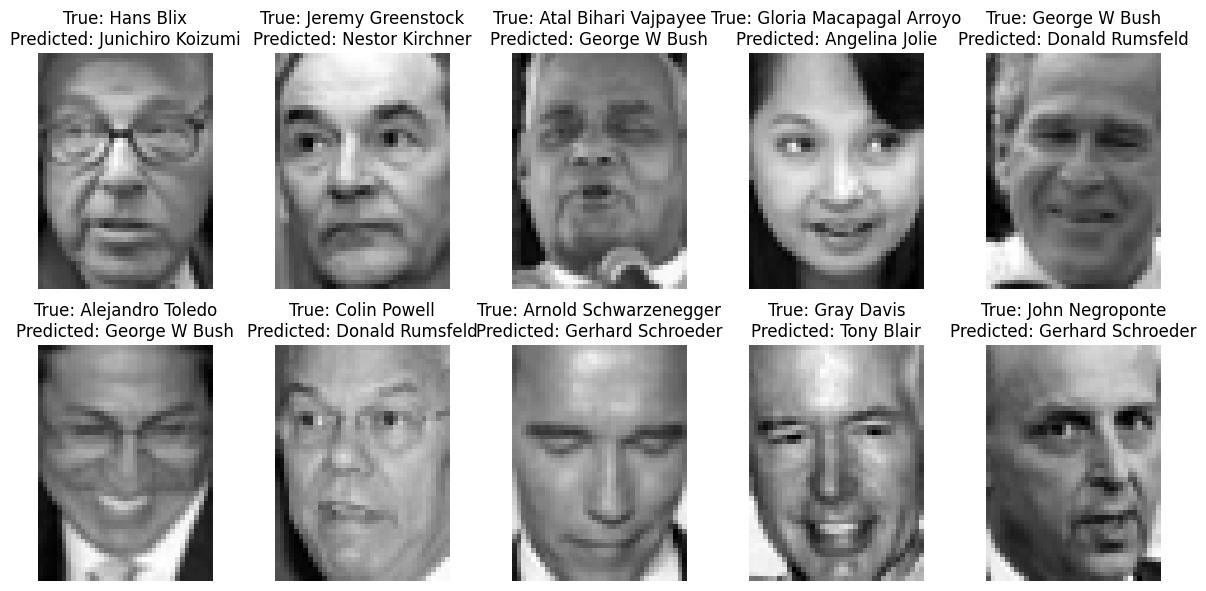

In [43]:
show_misclassified_images(X_test, y_test, y_pred, target_names)